In [159]:
from sys import stdout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, Reshape#, MaxPooling1D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from livelossplot.tf_keras import PlotLossesCallback

from sklearn.cross_decomposition import PLSCanonical
from scipy.signal import find_peaks


from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA

In [147]:
X = np.genfromtxt('C:/Users/alamg/Documents/MATLAB/Thesis/X_v3.csv', delimiter=',')
Y = np.genfromtxt('C:/Users/alamg/Documents/MATLAB/Thesis/Targets_v3.csv', delimiter=',')
w1= np.arange(0,3848,1)
w2=np.arange(0,101,1)
w3=np.linspace(400,700,101)
y= Y[:,0]
dP1 = []
dP2 = []
dP3 = []
dA1 = []
dA2 = []
dA3 = []
pos1 = []
pos2 = []
pos3 = []

X[1].shape

(5,)

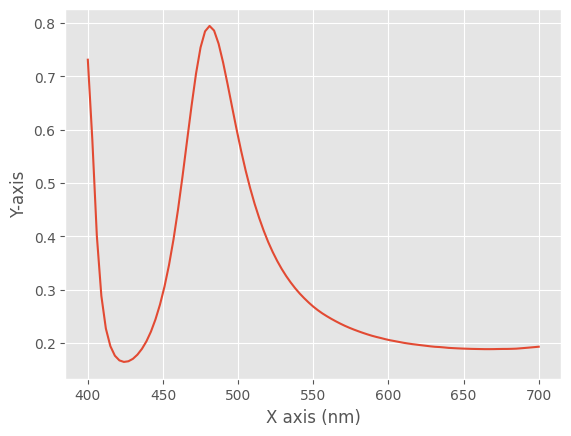

In [148]:
with plt.style.context('ggplot'):
    plt.plot(w3,Y[4,:])
    plt.xlabel("X axis (nm)")
    plt.ylabel("Y-axis")
    plt.show()

In [149]:
for i in w1:
    peaks, _ = find_peaks(Y[i,:],height=0.4)
    if len(peaks)==1:
      dP1.append(peaks)
      dA1.append(Y[peaks,:])
      pos1.append(i)  
    if len(peaks)==2:
        dP2.append(peaks)
        dA2.append(Y[peaks,:])
        pos2.append(i)  
    if len(peaks)==3:
        dP3.append(peaks)
        dA3.append(Y[peaks,:])
        pos3.append(i)

In [156]:
y_scaled = [dP1,dA1]

In [160]:
DENSE = 176      # Number of neurons in the DENSE (a.k.a Fully connected) layer
DROPOUT = 0.045  # Dropout rate
C1_K  = 14       # Number of kernels/filters for conv. first layer
C1_S  = 29       # Width of the filters for first conv. layer
C2_K  = 30       # Number of kernels/filters for second conv. layer
C2_S  = 22       # Width of the filters for second conv. layer

activation='relu'  # activation function (other possible options 'elu' or 'Leaky relu')

input_dim = X.shape[1]

## The model
def make_model():
    """ This functions outputs the CNN model already compiled """
    model = keras.Sequential()
    #Adding a bit of GaussianNoise also works as regularization
    model.add(keras.layers.GaussianNoise(0.01, input_shape=(input_dim,)))
    #First two is number of filter + kernel size
    model.add(keras.layers.Reshape((input_dim, 1)))
    model.add(keras.layers.Conv1D(C1_K, (C1_S), padding='same', activation=activation))
    model.add(keras.layers.Conv1D(C2_K, (C2_S), padding='same', activation=activation))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(DROPOUT))
    model.add(keras.layers.Dense(DENSE, activation=activation))
    model.add(keras.layers.Dense(1, activation='linear'))
    
    ## Compile options for the model
#     model.compile(loss='mse', optimizer=keras.optimizers.Adadelta(lr=0.01))#, metrics=['mean_absolute_error'])
#     model.compile(loss='mse', optimizer='adam')#, metrics=['mean_absolute_error'])
    model.compile(loss='huber_loss', optimizer=keras.optimizers.Adam(learning_rate=0.0004), metrics=['mean_absolute_error'])
#     model.compile(loss='huber_loss', optimizer='adam', metrics=['mean_squared_error'])
    return model

In [161]:
model_cnn=make_model()
print(model_cnn.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_3 (Gaussian  (None, 5)                 0         
 Noise)                                                          
                                                                 
 reshape_2 (Reshape)         (None, 5, 1)              0         
                                                                 
 conv1d_4 (Conv1D)           (None, 5, 14)             420       
                                                                 
 conv1d_5 (Conv1D)           (None, 5, 30)             9270      
                                                                 
 flatten_2 (Flatten)         (None, 150)               0         
                                                                 
 dropout_2 (Dropout)         (None, 150)               0         
                                                      

In [163]:
from livelossplot.tf_keras import PlotLossesCallback


rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)
early_stop = EarlyStopping(monitor='loss', min_delta=4e-4, patience=50, mode='auto', \
                                           restore_best_weights=True)
plot_losses = PlotLossesCallback(plot_extrema=False)
## Also, use or not the ReduceLOnPlateau() in the callbacks. In this case we have adam fixed at 0.0004 and only use early_stop.

h = model_cnn.fit(X, y_scaled , epochs=250, batch_size=45, validation_split=0.2, callbacks=[early_stop])

TypeError: MainLogger.__init__() got an unexpected keyword argument 'plot_extrema'